In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

### Lectura:

In [2]:
df_formations = pd.read_csv('C:/Users/guill/OneDrive/Escritorio/Actual/Master IA/ProjAp/Models/MatchAndStats.csv')
df_formations.shape

(15965, 882)

In [3]:
df_formations.sample(5)

,season,winning_team_formation,winner1_height,winner1_weight,winner1_overall_rating,winner1_potential,winner1_preferred_foot,winner1_attacking_work_rate,winner1_defensive_work_rate,winner1_crossing,...,loser11_vision,loser11_penalties,loser11_marking,loser11_standing_tackle,loser11_sliding_tackle,loser11_gk_diving,loser11_gk_handling,loser11_gk_kicking,loser11_gk_positioning,loser11_gk_reflexes
6590,2014/2015,4-5-1,190.50,198.0,82.333333,82.333333,0.0,1.0,1.0,25.000000,...,70.00,55.0,23.0,25.0,24.0,5.0,11.0,9.0,6.0,8.0
15288,2010/2011,3-4-3,185.42,183.0,71.000000,81.000000,0.0,1.0,1.0,11.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8400,2013/2014,3-5-2,187.96,165.0,67.166667,85.166667,1.0,1.0,1.0,22.083333,...,77.00,75.0,26.0,30.0,30.0,5.0,13.0,13.0,8.0,8.0
2271,2013/2014,4-5-1,193.04,181.0,82.250000,87.000000,1.0,1.0,1.0,25.000000,...,82.25,84.0,25.0,25.0,25.0,15.0,6.0,9.0,8.0,15.0
8782,2015/2016,4-3-3,193.04,192.0,76.800000,83.000000,1.0,1.0,1.0,13.000000,...,62.75,74.0,19.0,29.0,25.0,8.0,12.0,6.0,7.0,10.0


In [4]:
df_formations.columns

Index(['season', 'winning_team_formation', 'winner1_height', 'winner1_weight',
       'winner1_overall_rating', 'winner1_potential', 'winner1_preferred_foot',
       'winner1_attacking_work_rate', 'winner1_defensive_work_rate',
       'winner1_crossing',
       ...
       'loser11_vision', 'loser11_penalties', 'loser11_marking',
       'loser11_standing_tackle', 'loser11_sliding_tackle',
       'loser11_gk_diving', 'loser11_gk_handling', 'loser11_gk_kicking',
       'loser11_gk_positioning', 'loser11_gk_reflexes'],
      dtype='object', length=882)

## Train/Test Split:

In [5]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

formations = ['3-4-3', '3-5-2', '3-6-1', '4-3-3', '4-4-2', '4-5-1', '5-3-2', '5-4-1']

# OneHotEncoder
encoder = OneHotEncoder(categories=[formations])

encoded_formations = encoder.fit_transform(df_formations['winning_team_formation'].values.reshape(-1, 1))
encoded_formations_df = pd.DataFrame(encoded_formations.toarray(), columns=formations)
df_final = pd.concat([df_formations, encoded_formations_df], axis=1)

df_final.drop('winning_team_formation', axis=1, inplace=True)
df_final.fillna(0, inplace=True)

In [6]:
X = df_final.iloc[:,1:881]

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, encoded_formations_df, test_size=0.2, random_state=0)

print('Longitud Train =',len(X_train))
print('Longitud Test =',len(X_test))

Longitud Train = 12772
Longitud Test = 3193


In [8]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [9]:
len(y_train)

12772

In [10]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Oversample:

In [11]:
from imblearn.over_sampling import RandomOverSampler

# Define the oversampling strategy
oversample = RandomOverSampler(sampling_strategy='auto')

# Perform oversampling on the data
X_train_resampled, y_resampled = oversample.fit_resample(X_train_scaled, y_train)

# Reshape the oversampled one-hot encoded labels back to their original shape
y_train_resampled = y_resampled.reshape(-1, len(formations))


C:\Users\guill\Anacona\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [12]:
y_resampled_classes = np.argmax(y_resampled, axis=1)
y_train_classes = np.argmax(y_train, axis=1)
# Before oversampling
print(pd.Series(y_train_classes).value_counts())

# After oversampling
print(pd.Series(y_resampled_classes).value_counts())

4    4462
5    4403
3    3062
1     428
0     307
6      69
7      34
2       7
dtype: int64
0    4462
1    4462
2    4462
3    4462
4    4462
5    4462
6    4462
7    4462
dtype: int64


## Feature Reduction:

### Principal Component Analysis:

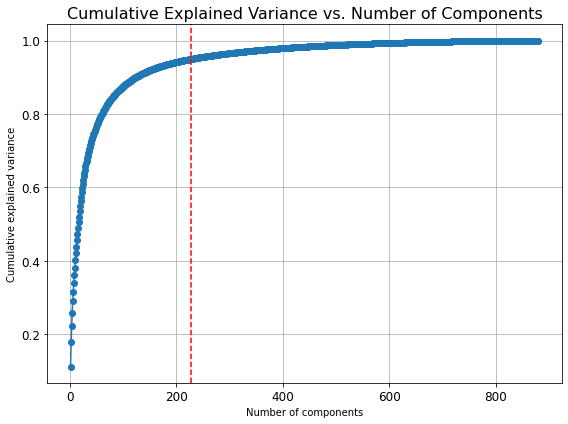

Elbow Point:  227


In [13]:
from sklearn.decomposition import PCA

# Perform PCA on the scaled training data
pca = PCA()
pca.fit(X_train_resampled)

# Calculate the cumulative explained variance
cumulative_var = np.cumsum(pca.explained_variance_ratio_)


# Plot the explained variance as a function of the number of components
plt.figure(figsize=(8, 6))

# Plot the cumulative explained variance
plt.plot(range(1, pca.n_components_ + 1), cumulative_var, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative Explained Variance vs. Number of Components')

# Find the elbow point
elbow_point = np.argmax(cumulative_var >= 0.95) + 1
plt.axvline(x=elbow_point, color='r', linestyle='--')

plt.xticks(fontsize=12)
#plt.xlim([0, 500])
plt.yticks(fontsize=12)
plt.grid(True)
plt.title('Cumulative Explained Variance vs. Number of Components', fontsize=16)
plt.tight_layout()
plt.show()

print('Elbow Point: ',elbow_point)

In [14]:
# Set the desired number of components based on the elbow curve
n_components = 227

# Perform PCA on the scaled training and test data
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled)

# Check the shape of the transformed data
print('Shape of X_train_pca:', X_train_pca.shape)
print('Shape of X_test_pca:', X_test_pca.shape)

Shape of X_train_pca: (35696, 227)
Shape of X_test_pca: (3193, 227)


### Boruta Algorithm:

In [ ]:
# Create a random forest classifier
rfc = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

# Create a Boruta feature selector
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=42)

# Fit the Boruta selector to the training data
boruta_selector.fit(X_train_resampled, y_resampled_classes)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	880
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	880
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	880
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	880
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	880
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	880
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	880
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	846
Tentative: 	34
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	846
Tentative: 	34
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	846
Tentative: 	34
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	846
Tentative: 	24
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	849
Tentative: 	21
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	849
Tentative: 	21
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	849
Tentative: 	21
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	849
Tentative: 	21
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	849

In [ ]:
# Check which features are selected
selected_features = X.columns[boruta_selector.support_]

# Transform the training and testing data to include only selected features
X_train_selected = boruta_selector.transform(X_train_resampled)
X_test_selected = boruta_selector.transform(X_test_scaled)

In [ ]:
estimator=RandomForestClassifier(class_weight='balanced',
                                          n_estimators=415, n_jobs=-1,
                                          random_state=0)

estimator.fit(X_train_selected, y_resampled_classes)

# Predict on the test set
y_pred_classes = estimator.predict(X_test_selected)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy and F1-score
accuracy = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F1-score:', f1)

In [ ]:
X_train_selected_df = pd.DataFrame(X_train_selected)
X_test_selected_df = pd.DataFrame(X_test_selected)

X_train_selected_df.to_csv('C:/Users/guill/OneDrive/Escritorio/Actual/Master IA/ProjAp/Models/X_train_selected_df.csv', index=False)
X_test_selected_df.to_csv('C:/Users/guill/OneDrive/Escritorio/Actual/Master IA/ProjAp/Models/X_test_selected_df.csv', index=False)

## Predictions with OVS:

### Linear Regresion:

In [ ]:
from sklearn.linear_model import LinearRegression

########################### MODEL
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train_resampled, y_resampled)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
########################### EVALUATION

y_true = np.argmax(y_test, axis=1)

predicted_formations = np.zeros((len(y_pred_classes), 8))
predicted_formations[np.arange(len(y_pred_classes)), y_pred_classes] = 1
predicted_formations = encoder.inverse_transform(predicted_formations)

true_formations = np.zeros((len(y_true), 8))
true_formations[np.arange(len(y_true)), y_true] = 1
true_formations = encoder.inverse_transform(true_formations)

# Generate confusion matrix
confusion_mtx = confusion_matrix(true_formations, predicted_formations, labels=formations)

# Normalize confusion matrix by class counts
confusion_mtx_norm = confusion_mtx / class_counts[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mtx_norm, cmap="Blues", annot=True, fmt='.2f', 
            xticklabels=formations, yticklabels=formations)
plt.xlabel('Predicted formation')
plt.ylabel('True formation')
plt.title('Confusion matrix (normalized by class counts)')
plt.show()

# Print accuracy and F1 score
accuracy = accuracy_score(true_formations, predicted_formations)
f1 = f1_score(true_formations, predicted_formations, average='weighted')
print('Accuracy:', accuracy)
print('F1 score:', f1)

### Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

########################### MODEL
# Instantiate the model
model = RandomForestClassifier(random_state=0)

# Fit the model to the training data
model.fit(X_train_resampled, y_resampled_classes)

# Make predictions on the test data
y_pred_classes = model.predict(X_test_scaled)

########################### EVALUATION

y_true = np.argmax(y_test, axis=1)

predicted_formations = np.zeros((len(y_pred_classes), 8))
predicted_formations[np.arange(len(y_pred_classes)), y_pred_classes] = 1
predicted_formations = encoder.inverse_transform(predicted_formations)

true_formations = np.zeros((len(y_true), 8))
true_formations[np.arange(len(y_true)), y_true] = 1
true_formations = encoder.inverse_transform(true_formations)

# Generate confusion matrix
confusion_mtx = confusion_matrix(true_formations, predicted_formations, labels=formations)

# Normalize confusion matrix by class counts
confusion_mtx_norm = confusion_mtx / class_counts[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mtx_norm, cmap="Blues", annot=True, fmt='.2f', 
            xticklabels=formations, yticklabels=formations)
plt.xlabel('Predicted formation')
plt.ylabel('True formation')
plt.title('Confusion matrix (normalized by class counts)')
plt.show()

# Print accuracy and F1 score
accuracy = accuracy_score(true_formations, predicted_formations)
f1 = f1_score(true_formations, predicted_formations, average='weighted')
print('Accuracy:', accuracy)
print('F1 score:', f1)

### Neural Network:

#### Model:

In [ ]:
bAIcelona = models.Sequential([
    layers.Dense(1024, activation='elu', input_dim=X_train_resampled.shape[1]),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(2048, activation='elu'),
    layers.BatchNormalization(),
    layers.Dropout(0.6),

    layers.Dense(1024, activation='elu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(512, activation='elu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Dense(256, activation='elu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(128, activation='elu'),
    layers.BatchNormalization(),
    layers.Dropout(0.15),

    layers.Dense(y_resampled.shape[1], activation='softmax')
])

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0075)
early_stopping = EarlyStopping(monitor='val_loss', patience=35, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1)
bAIcelona.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = bAIcelona.fit(X_train_resampled, y_resampled, epochs=1000, batch_size=1024, 
                    validation_data=(X_test_scaled, y_test), 
                    callbacks=[early_stopping, reduce_lr])

#### Load:

In [ ]:
#### create figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# plot loss on first subplot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss over Epochs', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(fontsize=14)

# add vertical line at point of early stopping
if 'val_loss' in history.history:
    early_stop_epoch = len(history.history['val_loss'])
    ax1.axvline(x=early_stop_epoch, linestyle='--', color='grey')

# plot accuracy on second subplot
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy over Epochs', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend(fontsize=14)

# add vertical line at point of early stopping
if 'val_accuracy' in history.history:
    early_stop_epoch = len(history.history['val_accuracy'])
    ax2.axvline(x=early_stop_epoch, linestyle='--', color='grey')

# display the plot
plt.show()

In [ ]:
bAIcelona = load_model('C:/Users/guill/OneDrive/Escritorio/Actual/bAIcelona.h5')

In [ ]:
# Predict on the test set
y_pred = bAIcelona.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

predicted_formations = np.zeros((len(y_pred_classes), 8))
predicted_formations[np.arange(len(y_pred_classes)), y_pred_classes] = 1
predicted_formations = encoder.inverse_transform(predicted_formations)

true_formations = np.zeros((len(y_true), 8))
true_formations[np.arange(len(y_true)), y_true] = 1
true_formations = encoder.inverse_transform(true_formations)

# Generate confusion matrix
confusion_mtx = confusion_matrix(true_formations, predicted_formations, labels=formations)

# Normalize confusion matrix by class counts
confusion_mtx_norm = confusion_mtx / class_counts[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mtx_norm, cmap="Blues", annot=True, fmt='.2f', 
            xticklabels=formations, yticklabels=formations)
plt.xlabel('Predicted formation')
plt.ylabel('True formation')
plt.title('Confusion matrix (normalized by class counts)')
plt.show()

# Print accuracy and F1 score
accuracy = accuracy_score(true_formations, predicted_formations)
f1 = f1_score(true_formations, predicted_formations, average='weighted')
print('Accuracy:', accuracy)
print('F1 score:', f1)


In [ ]:
bAIcelona.save('C:/Users/guill/OneDrive/Escritorio/Actual/bAIcelona.h5')

## Predictions without OVS:

### LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression

########################### MODEL
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

########################### EVALUATION
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Calculate number of samples in each true label class
class_counts = np.bincount(y_true)

# Normalize confusion matrix by class counts
confusion_mtx_norm = confusion_mtx / class_counts[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mtx_norm, cmap="Blues", annot=True, fmt='.2f')
plt.xlabel('Planned tags')
plt.ylabel('True tags')
plt.title('Confusion matrix (normalized by class counts)')
plt.show()

# Print accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F1 score:', f1)

### RandomForestClassifier:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

########################### MODEL
# Instantiate the model
model = RandomForestClassifier(random_state=0)

# Fit the model to the training data
model.fit(X_train_scaled, y_train_classes)

# Make predictions on the test data
y_pred_classes = model.predict(X_test_scaled)

########################### EVALUATION

y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Calculate number of samples in each true label class
class_counts = np.bincount(y_true)

# Normalize confusion matrix by class counts
confusion_mtx_norm = confusion_mtx / class_counts[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mtx_norm, cmap="Blues", annot=True, fmt='.2f')
plt.xlabel('Planned tags')
plt.ylabel('True tags')
plt.title('Confusion matrix (normalized by class counts)')
plt.show()

# Print accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F1 score:', f1)

### Neural Network Model:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build a neural network to predict the positions
bAIcelona2 = tf.keras.Sequential([
    Dense(128, activation='LeakyReLU', input_dim=X_train_resampled.shape[1]),
    Dropout(0.4),
    Dense(256, activation='LeakyReLU'),
    Dropout(0.5),
    Dense(128, activation='LeakyReLU'),
    Dropout(0.4),
    Dense(128, activation='LeakyReLU'),
    Dropout(0.4),
    Dense(64, activation='LeakyReLU'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0075)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, verbose=1)
bAIcelona2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = bAIcelona2.fit(X_train_scaled, y_train, epochs=1000, batch_size=128, 
                    validation_data=(X_test_scaled, y_test), 
                    callbacks=[early_stopping, reduce_lr])

In [ ]:
#### create figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# plot loss on first subplot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss over Epochs', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(fontsize=14)

# add vertical line at point of early stopping
if 'val_loss' in history.history:
    early_stop_epoch = len(history.history['val_loss'])
    ax1.axvline(x=early_stop_epoch, linestyle='--', color='grey')

# plot accuracy on second subplot
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy over Epochs', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend(fontsize=14)

# add vertical line at point of early stopping
if 'val_accuracy' in history.history:
    early_stop_epoch = len(history.history['val_accuracy'])
    ax2.axvline(x=early_stop_epoch, linestyle='--', color='grey')

# display the plot
plt.show()

In [ ]:
# Predict on the test set
y_pred = bAIcelona2.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

predicted_formations = np.zeros((len(y_pred_classes), 8))
predicted_formations[np.arange(len(y_pred_classes)), y_pred_classes] = 1
predicted_formations = encoder.inverse_transform(predicted_formations)

true_formations = np.zeros((len(y_true), 8))
true_formations[np.arange(len(y_true)), y_true] = 1
true_formations = encoder.inverse_transform(true_formations)

# Generate confusion matrix
confusion_mtx = confusion_matrix(true_formations, predicted_formations, labels=formations)

# Normalize confusion matrix by class counts
confusion_mtx_norm = confusion_mtx / class_counts[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mtx_norm, cmap="Blues", annot=True, fmt='.2f', 
            xticklabels=formations, yticklabels=formations)
plt.xlabel('Predicted formation')
plt.ylabel('True formation')
plt.title('Confusion matrix (normalized by class counts)')
plt.show()

# Print accuracy and F1 score
accuracy = accuracy_score(true_formations, predicted_formations)
f1 = f1_score(true_formations, predicted_formations, average='weighted')
print('Accuracy:', accuracy)
print('F1 score:', f1)

In [ ]:
bAIcelona2.save('C:/Users/guill/OneDrive/Escritorio/Actual/bAIcelona2.h5')

## Pruebas:

In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the input shape of the data
input_shape = (image_height, image_width, num_channels)

# Construct a CNN to predict positions
model = tf.keras.Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train,, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test_scaled, y_test))
